## 이미지 읽어와 bgr->rgb 변환
---

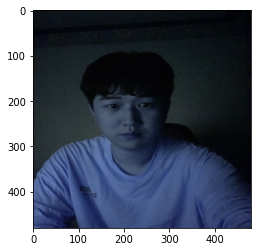

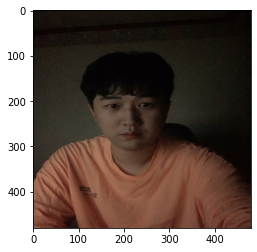

In [1]:
import cv2
from cv2 import resize
import matplotlib.pyplot as plt
import numpy as np
import os

my_image_path = os.getenv('HOME') + '/aiffel/cat_whiskers/js6.png'
img_bgr = cv2.imread(my_image_path) # opencv로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 480)) # 360x360 크기로 resizer
img_show = img_bgr.copy() # 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

# opencv 는 bgr로 받으므로 변환해줘야 한다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## dlib를 이용해 얼굴 bounding box 추출
- - -

rectangles[[(132, 167) (287, 322)]]


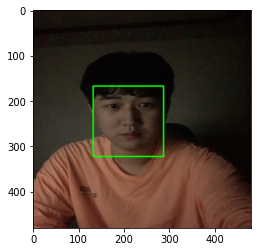

In [2]:
import dlib
detector_hog = dlib.get_frontal_face_detector()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1) # 두번째 인자는 이미지 피라미드의 수

print(dlib_rects) # 찾은 얼굴 영역 좌표

# dlib detector는 dlib.rectangles 타입의 객체를 반환한다.
# dlibe.ractangles는 dlib.rectangle 객체의 배열 형태로 이루어져 있다.
# dlibe.rectangle 객체는 left(), top(), right(), bottom(), height(), width() 등의 멤버함수를 포함하고 있다.
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()
    
    cv2.rectangle(img_show, (l,t), (r,b), (0, 255, 0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## bounding box 내부의 keypoint를 예측(landmark localization)
- - -

68


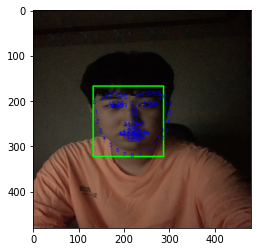

In [3]:
model_path = os.getenv('HOME') + '/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect) # RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
    
print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        #cv2.circle(img_show, point, 2, (0, 255, 255), -1)  #yellow
        cv2.putText(img_show, str(idx), point, cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,0,0), 1)
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 스티커 적용하기
---

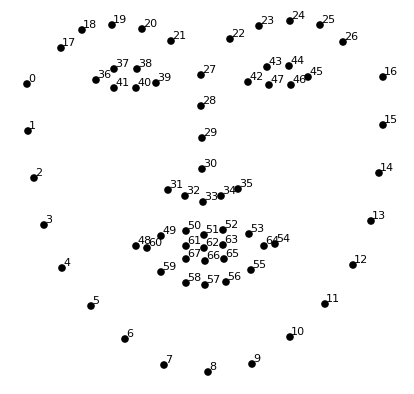</img><br/>

In [4]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print(landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1]
    #x = (landmark[30][0] - landmark[2][0]) 
    #y = (landmark[48][1] - landmark[36][1])
    w = dlib_rect.width()
    h = dlib_rect.height()
    print('(x,y) : (%d, %d)'%(x,y))
    print('(w,h) : (%d, %d)'%(w,h))

(215, 247)
(x,y) : (215, 247)
(w,h) : (156, 156)


In [5]:
sticker_path = os.getenv('HOME') + '/aiffel/cat_whiskers/cat_whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h)) #bounding width, height 크기로 사이즈 조정
print(img_sticker.shape)

(156, 156, 3)


In [6]:
#refined_x = x - w//2 #left
#refined_y = y-h    #top
refined_x = x - w//2
refined_y = y - h//2
print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (137,169)


## Bounding box와 landmark 제거한 최종 출력
---

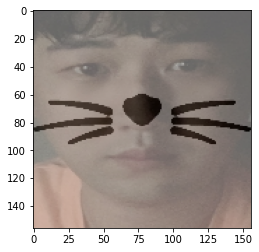

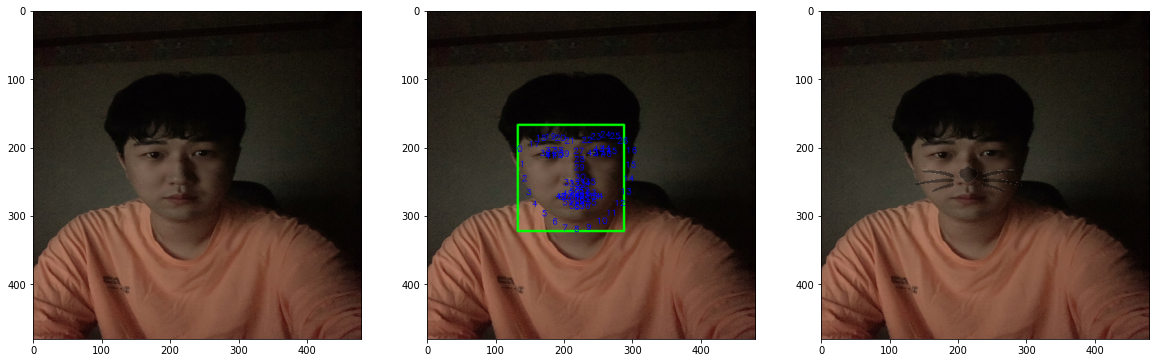

In [7]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 투명한 고양이 수염을 붙이기 위해 img_tmp에 sticker_area와 img_sticker 0.6:0.4 비율로 합처놓음
img_tmp = cv2.addWeighted(sticker_area, 0.6, img_sticker, 0.4, 0)

plt.imshow(cv2.cvtColor(img_tmp, cv2.COLOR_BGR2RGB))
plt.show()

# np.where 조건문 img_sticker 의 색상값이 200 초과인 부분은 sticker_area 사용, 이하인 부분은 img_tmp 사용
img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker>250, sticker_area, img_tmp).astype(np.uint8)

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1, 3, 1)
ax.imshow(img_rgb)
ax = fig.add_subplot(1, 3, 2)
ax.imshow(img_show_rgb)
ax = fig.add_subplot(1, 3, 3)
ax.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))



# 결과 보고서
---

## Image_1
![img1](./cat_whiskers/result1.png)
> 얼굴 각도 옆으로 틀었을 경우            
> 이미지 파라미터 수 1->2 로 증가 시킨 후 bounding box 정상적으로 찾음
## Image_2
![img1](./cat_whiskers/result2.png)
> 얼굴 각도 정면 인 경우           
> 이미지 파라미터 수 1로 bounding box 찾음
## Image_3
![img1](./cat_whiskers/result3.png)
> 촬영거리 늘리고 얼굴 각도 옆으로 틀었을 경우    
> 이미지 파라미터 수 1로 bounding box 찾음
## Image_4
![img1](./cat_whiskers/result4.png)
> 촬영 거리 늘리고 얼굴 각도 정면 인 경우           
> 이미지 파라미터 수 1로 bounding box 찾음
## Image_5
![img1](./cat_whiskers/result5.png)
> 이미지 밝기 낮추고 얼굴 각도 틀었을 경우   
> 이미지 파라미터 수 1로 bounding box 찾음
## Image_6
![img1](./cat_whiskers/result6.png)
> 이미지 밝기 낮추고 얼굴 각도 정면 인 경우        
> 이미지 파라미터 수 1로 bounding box 찾음
## Image_7
![img1](./cat_whiskers/result7.png)
> 사진 90도 틀었을 경우       
> 이미지 파라미터 수 1~7까지 테스트 결과 bounding box 찾지 못함. 이상 테스트 시 커널 뻗음.

##최종 결론    
---

dlib 라이브러리에서 HOG 방식을 사용하는데 HOG 방식이 하나의 픽셀이 둘러 싸고 있는 픽셀들과 비교해서 얼마나 어두운지를 알아내 이미지가 어두워지는 방향으로 `화살표(Gradient)`를 그린다. 또한 이미지를 16x16픽셀의 작은 정사각형으로 분해해 자세한 정보보다는 패턴을 파악 후 위 작업을 진행하여 얼굴을 찾는다.   
1. 촬영 거리를 늘리게 되면 16x16 픽셀의 작은 정사각형으로 분해 시 특정 픽셀의 밝기 값등이 무시될 수 있기 때문에 `화살표`를 정상적으로 못찾게 돼 Bounding Box를 못찾는다.    
2. 이미지 밝기값이 너무 어두워져 주변 픽셀들과의 밝기값 차이가 거의 나지 않는다면 `화살표`를 정상적으로 못찾게 돼 Bounding Box를 못찾는다. 
3. 옆으로 90도 회전 시킨 이미지 같은 경우 얼굴의 특징점의 위치가 전부 틀어지기 때문에 Bounding box를 찾기 힘들다.

## 회고
---
- 이번 프로젝트에서 **어려웠던 점,**
    - 고양이 수염을 투명하게 붙히는게 어려웠다. np.where 조건에서 기존 이미지에 고양이 수염을 붙혀버리기 때문에 처음에는 고양이 수염 이미지를 투명화를 진행 후 기존 이미지에 붙힐까 진행할까 생각 하였지만, 노드에서 cv2.addWeighted() 함수를 사용하라고 했기 때문에 위와 같은 방식(img_temp 에 sticker_area와 img_stick를 투명도 비율 0.6:0.4 비율로 미리 만들어 놓음)으로 처리하였다.
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
     - 얼굴 인식 알고리즘에 프로세스를 좀 더 이해하였다.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
     - 이미지 파라미터를 변경하여 Bounding Box를 찾도록 노력하였다.
     - 여러 블로그를 돌아다니며 얼굴 인식 알고리즘에 대하여 이해하려고 노력하였다.
- **자기 다짐**
     - 다음부터는 해당 루브릭에만 맞추려고 하지 말고 해당 프로그램을 개선할 수 있도록 노력해보자.
     - 미리 미리 진행하여 시간에 덜 쫓기도록 하자.